Welcome to the workshop "from devices to datasets". This workshop is accompanied by an exercise sheet, use this sheet to go through the code!

Section 1+2: add your folder directory and performed interventions in the first section

In [32]:
# Select kernel: Python (Tutorial 4)

In [33]:
# Fill in your folderDirectory and performed interventions
# folderDirectory = r"C:\YOURDIRECTORY" # Windows
folderDirectory = "/YOURDIRECTORY" # Linux
interventions = ["rest", "6bpm","handgrip"]  # from example dataset

In [23]:
import os
import easygui
import pandas as pd #2.3.3
import datetime
import re
import matplotlib.pyplot as plt
import numpy as np

fs = 128

packageSizeEcg = 32  # package size ECG
packageSize = 12  # package size other
crystalFreq = 32768  # conversion crystal time to sec

"""
Run this section and select a recording with the GUI. 
Make sure you have at least two folders present in your directory to prevent an error.
"""

recList = os.listdir(folderDirectory)
selectRec = easygui.choicebox('Select recording','Recording selection',recList)
# subjectFolder = folderDirectory + "\\" + str(selectRec) # Windows
subjectFolder = os.path.join(folderDirectory, str(selectRec)) # Linux


# This section loads the relevant Calamari data from the subjectFolder
# and will sort and interpolate the data
timemarkers = pd.DataFrame
# timestamps = pd.read_csv(subjectFolder + r"\{}".format('nl.imec.hawk.timestamp.csv')) # Windows
timestamps = pd.read_csv(subjectFolder + "/{}".format("nl.imec.hawk.timestamp.csv")) # Linux

startIdx = timestamps['timestamp'].str.contains('start at')
stopIdx = timestamps['timestamp'].str.contains('end at')
timemarkers.start = timestamps['time'][startIdx]
timemarkers.stop = timestamps['time'][stopIdx]

# Calculate start delay
start_time_hawk = timestamps['time'][startIdx].values[0]
start_time_sec = start_time_hawk / 32768

# Read signals
# ecgFile = pd.read_csv(subjectFolder + r"\{}".format('nl.imec.hawk.ecg2.csv')) # Windows
# scgFile = pd.read_csv(subjectFolder + r"\{}".format('nl.imec.hawk.accel.z.csv')) # Windows
# ppgFile = pd.read_csv(subjectFolder + r"\{}".format('nl.imec.hawk.ppg.ir.csv')) # Windows
ecgFile = pd.read_csv(subjectFolder + "/{}".format('nl.imec.hawk.ecg2.csv')) # Linux
scgFile = pd.read_csv(subjectFolder + "/{}".format('nl.imec.hawk.accel.z.csv')) # Linux
ppgFile = pd.read_csv(subjectFolder + "/{}".format('nl.imec.hawk.ppg.ir.csv')) # Linux

# sortandcheck function to sort and interpolate the respective data
ecgFile = ((ecgFile.sort_values(by=['sequence_counter'])).drop_duplicates('sequence_counter')).interpolate()
scgFile = ((scgFile.sort_values(by=['sequence_counter'])).drop_duplicates('sequence_counter')).interpolate()
ppgFile = ((ppgFile.sort_values(by=['sequence_counter'])).drop_duplicates('sequence_counter')).interpolate()

# rescale data
scgFile['accel.z'] = scgFile['accel.z'] * (4/pow(2, 16))  # set to +/-2g (4g range with 16bit data structure) -> 4/2^16
ppgFile['ppg.ir'] = -1*ppgFile['ppg.ir']
ecgFile['time'] = ecgFile['time'] - 4906 # fixed ECG delay

# interpolate data
timeinterpolated = np.array(range(int(timemarkers.start),int(list(ecgFile['time'])[-1]),fs))
ECGinterpolated = np.interp(timeinterpolated, ecgFile['time'], ecgFile['ecg2'])
SCGinterpolated = np.interp(timeinterpolated, scgFile['time'], scgFile['accel.z'])
PPGinterpolated = np.interp(timeinterpolated, ppgFile['time'], ppgFile['ppg.ir'])

# list intervention timing
timemarkers.start_events = []
timemarkers.stop_events = []
for idx, intervention in enumerate(interventions):
    start_event = timestamps['timestamp'].str.contains("start " + intervention)
    timemarkers.start_events.append(timestamps['time'][start_event])

    stop_event = timestamps['timestamp'].str.contains("stop " + intervention)
    timemarkers.stop_events.append(timestamps['time'][stop_event])

print("Selected recording: " + str(selectRec))
# print("Selected recording: " + str(selectSub) + " " + str(selectRec))


Selected recording: long_recording_1


/tmp/ipykernel_8242/143551371.py:60: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  timeinterpolated = np.array(range(int(timemarkers.start),int(list(ecgFile['time'])[-1]),fs))


Section 3: Display raw data

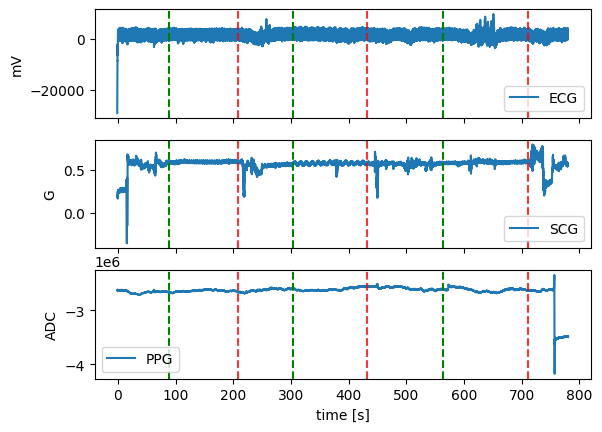

In [24]:
# Plot your data in this section
downsamp = 1  # choose down sampling rate for plotting to reduce plotting time and memory

# Plot all data
fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(ecgFile.time[::downsamp]/crystalFreq-start_time_sec, ecgFile['ecg2'][::downsamp])
ax[0].legend(['ECG'])
ax[0].set_ylabel('mV')
ax[1].plot(scgFile.time[::downsamp]/crystalFreq-start_time_sec, scgFile['accel.z'][::downsamp])
ax[1].legend(['SCG'])
ax[1].set_ylabel('G')
ax[2].plot(ppgFile.time[::downsamp]/crystalFreq-start_time_sec, ppgFile['ppg.ir'][::downsamp])
ax[2].legend(['PPG'])
ax[2].set_ylabel('ADC')
ax[2].set_xlabel('time [s]')

# Plot start and stop of interventions
for i, a in enumerate(ax.reshape(-1)):
    for x in list(timemarkers.start_events): 
        ax[i].axvline(x.iloc[0]/crystalFreq-start_time_sec, color='green', linestyle='--')
    for y in timemarkers.stop_events:
        ax[i].axvline(y.iloc[0]/crystalFreq-start_time_sec, color='red', linestyle='--', alpha=0.8)

plt.show()

Section 4: Display data segment of a specific intervention

/tmp/ipykernel_8242/1926808222.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  start = int(timemarkers.start_events[idxIntervention])
/tmp/ipykernel_8242/1926808222.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  stop = int(timemarkers.stop_events[idxIntervention])


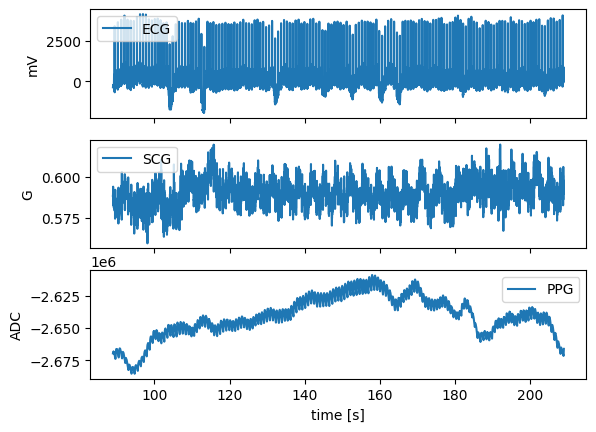

In [25]:
# Select segment to analyse
intervention = 'rest'  #Available interventions: rest, 6bpm, handgrip

idxIntervention = interventions.index(intervention)

# get data within range of intervention
start = int(timemarkers.start_events[idxIntervention])
stop = int(timemarkers.stop_events[idxIntervention])

# Select segment of intervention
idxSegment = (timeinterpolated >= start) & (timeinterpolated <= stop)
scgSegment = SCGinterpolated[idxSegment]
ecgSegment = ECGinterpolated[idxSegment]
ppgSegment = PPGinterpolated[idxSegment]
timeSegment = timeinterpolated[idxSegment]/crystalFreq-start_time_sec

# Plot all data
fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(timeSegment,ecgSegment)
ax[0].legend(['ECG'])
ax[0].set_ylabel('mV')
ax[1].plot(timeSegment,scgSegment)
ax[1].legend(['SCG'])
ax[1].set_ylabel('G')
ax[2].plot(timeSegment,ppgSegment)
ax[2].legend(['PPG'])
ax[2].set_ylabel('ADC')
ax[2].set_xlabel('time [s]')
plt.show()



Section 5: Pre-processing of your data and fiducial detection

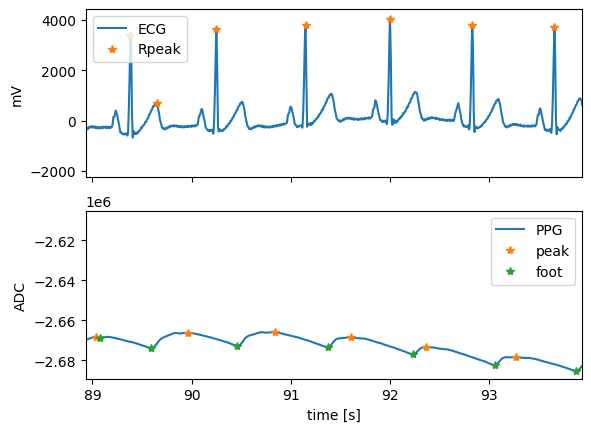

In [26]:
import neurokit2 as nk
import scipy.signal

# Find R-peaks
"""Try finding Rpeaks without filtering"""
_, ecg_info = nk.ecg_peaks(ecgSegment, sampling_rate=fs, show=False)

"""And with filtering!"""
# _, ecg_info = nk.ecg_peaks(nk.ecg_clean(ecgSegment,method='vg'), sampling_rate=fs, show=False)
#note: you can change the cleaning method, use for exapmle 'vg' or 'neurokit' or 'biosppy'

rpeaks = ecg_info["ECG_R_Peaks"] 

"""First: continue processing without filtering, and try again with filtering after"""
if 0:
    # baseline removal
    fCutHz = .5
    fCutNorm = fCutHz * 2 / fs
    order = 2
    sosBaRmv = scipy.signal.butter(order, fCutNorm, 'high', output="sos")
    ppgFiltered = scipy.signal.sosfiltfilt(sosBaRmv, ppgSegment)
    
    peaks, _ = scipy.signal.find_peaks(ppgFiltered, prominence=0.2, distance=int(fs * 1))
    valleys, _ = scipy.signal.find_peaks(-ppgFiltered, prominence=0.2, distance=int(fs * 1))
else:
    # Find PPG fiducials
    peaks, _ = scipy.signal.find_peaks(ppgSegment, prominence=0.2, distance=int(fs * 1))
    valleys, _ = scipy.signal.find_peaks(-ppgSegment, prominence=0.2, distance=int(fs * 1))


"""Here you can zoom in on a certain segment to look at it in more detail"""
# Zoom in on plot to see the results:
start_sec = start/crystalFreq-start_time_sec
limit = [start_sec+0,start_sec+5]

# Plot data with fiducials
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(timeSegment, ecgSegment)
ax[0].plot(timeSegment[rpeaks],ecgSegment[rpeaks],"*")
ax[0].legend(['ECG','Rpeak'])
ax[0].set_ylabel('mV')

ax[1].plot(timeSegment, ppgSegment)
ax[1].plot(timeSegment[peaks], ppgSegment[peaks], "*")
ax[1].plot(timeSegment[valleys], ppgSegment[valleys], "*")
ax[1].legend(['PPG','peak','foot'])
ax[1].set_ylabel('ADC')
ax[1].set_xlabel('time [s]')
plt.xlim(limit)
plt.show()

Section 6: Post-processing and HR and PAT calculation

'P.S. handgrip activity lasted 30 seconds, can you see it ??'

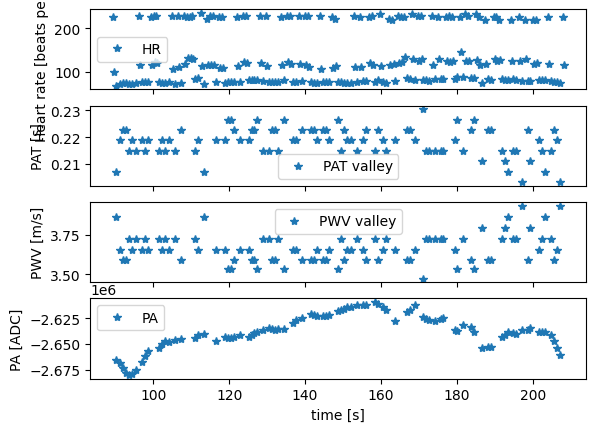

In [27]:
import numpy as np

# HR from ECG
ibi = np.diff(timeSegment[rpeaks])
hr = 60/ibi

# PAT peak vs foot
PAT_peak = []

selectedpeaks = []
selectedrpeaks= []
selectedvalleys = []
refinedrpeaks = []
refinedrpeaktimes = []
refinerpeak = 1

# Find all Rpeaks with matching PPG peak and valley
for count, rr in enumerate(rpeaks[0:-1]):
    currRpeak = timeSegment[rpeaks[count]] 
    nextRpeak = timeSegment[rpeaks[count+1]]

    idxpeak = (timeSegment[peaks] > currRpeak) & (timeSegment[peaks] < nextRpeak)
    idxvalley = (timeSegment[valleys] > currRpeak) & (timeSegment[valleys] < nextRpeak)

    if (valleys[idxvalley].size > 0) & (peaks[idxpeak].size > 0):
        selectedpeaks.append(int(peaks[idxpeak][0]))
        selectedvalleys.append(int(valleys[idxvalley][0]))
        selectedrpeaks.append(int(rpeaks[count]))

        """The device has a limited time resolution. The section below refines the R-peak position:"""
        if refinerpeak:
            prev_y = ecgSegment[rpeaks[count]-1]
            curr_y = ecgSegment[rpeaks[count]]
            next_y = ecgSegment[rpeaks[count]+1]
            
            # Fit a quadratic polynomial through the three points
            x = np.array([-1, 0, 1])
            y = np.array([prev_y, curr_y, next_y])
            coeffs = np.polyfit(x, y, 2)
        
            # The vertex of the parabola (maximum) is given by -b/(2a)
            a, b, c = coeffs
            if a != 0:
                refined_peak_offset = -b / (2 * a)
            else:
            # If a is zero, the data is linear; use original peak
                refined_peak_offset = 0

            refined_peak = ecgSegment[rpeaks[count]] + refined_peak_offset
            refinedrpeaks.append(refined_peak)
            
            # Linearly interpolate the time for the refined peak
            refined_time = np.interp(refined_peak, [prev_y, curr_y, next_y],
                                     timeSegment[rpeaks[count] - 1:rpeaks[count] + 2])
            refinedrpeaktimes.append(refined_time)

            # option to do the same for the PPG fiducials
        
# calculate Pulse arrival time (PAT)
if refinerpeak: 
    PAT_peak = timeSegment[selectedpeaks] - refinedrpeaktimes
    PAT_foot = timeSegment[selectedvalleys] - refinedrpeaktimes
else:
    PAT_peak = timeSegment[selectedpeaks] - timeSegment[selectedrpeaks]
    PAT_foot = timeSegment[selectedvalleys] - timeSegment[selectedrpeaks]

PWV_peak = 0.8/PAT_peak # assumme arm length of 80 cm
PWV_foot = 0.8/PAT_foot

""" Complete this calculation """
PA = ppgSegment[selectedpeaks] 

# plot HR and PAT
fig, ax = plt.subplots(4, 1, sharex=True)
ax[0].plot(timeSegment[rpeaks[0:-1]],hr,"*")
ax[0].legend(['HR'])
ax[0].set_ylabel('Heart rate [beats per min]')

ax[1].plot(timeSegment[selectedrpeaks], PAT_foot, "*")
ax[1].legend(['PAT valley'])
# ax[1].plot(timeSegment[selectedrpeaks], PAT_peak, "+")
# ax[1].legend(['PPG peak, PPG valley'])
ax[1].set_ylabel('PAT [s]')

ax[2].plot(timeSegment[selectedrpeaks], PWV_foot, "*")
ax[2].legend(['PWV valley'])
ax[2].set_ylabel('PWV [m/s]')

ax[3].plot(timeSegment[selectedrpeaks], PA, "*")
ax[3].legend(['PA'])
ax[3].set_ylabel('PA [ADC]')

ax[3].set_xlabel('time [s]')


"""P.S. handgrip activity lasted 30 seconds, can you see it ??"""

# Plot data with fiducials
# fig, ax = plt.subplots(2, 1, sharex=True)
# ax[0].plot(timeSegment, ecgSegment)
# ax[0].plot(timeSegment[selectedrpeaks],ecgSegment[selectedrpeaks],"x")
# ax[0].plot(refinedrpeaktimes,refinedrpeaks,"+")

# ax[0].legend(['ECG','ECG peak','refined time'])
# ax[0].set_ylabel('mV')

# ax[1].plot(timeSegment, ppgSegment)
# ax[1].plot(timeSegment[peaks], ppgSegment[peaks], "*")
# ax[1].plot(timeSegment[valleys], ppgSegment[valleys], "*")
# ax[1].legend(['PPG'])
# ax[1].set_ylabel('ADC')
# ax[1].set_xlabel('time [s]')
# plt.xlim(limit)
# plt.show()

You might see some segments with false HR or PAT readings. Zoom in on those segments with the raw signal in the sections above to see what is happening!

Section 7: Let's try the impact on a little model; we recommend you to look at an intervention with paced breathing or activity

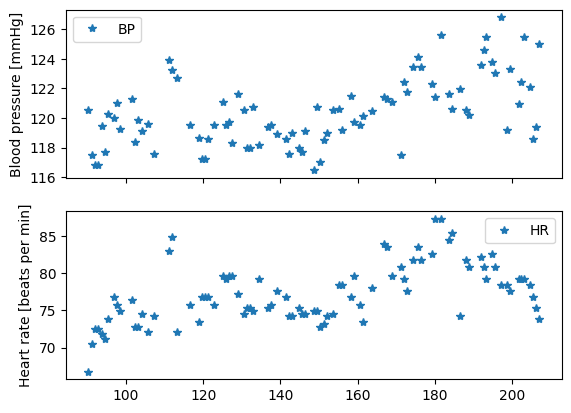

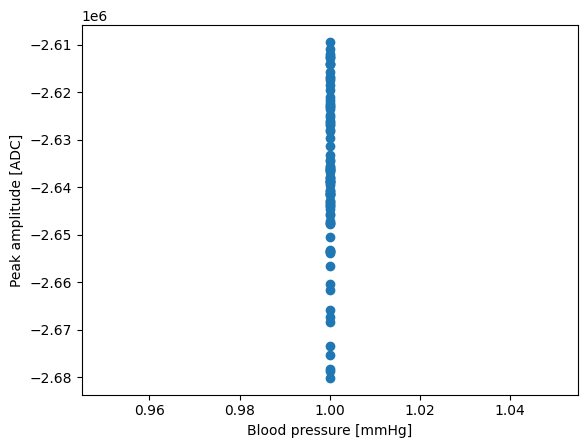

'P.S. handgrip activity lasted 30-45 seconds, can you see it ?'

In [29]:
# DISCLAIMER: this section shows estimated blood pressure. This is a simplified model 
# which is not verified. So no actual health information can be derived from the values.

# select only relevant Rpeaks
xy, x_ind, y_ind = np.intersect1d(rpeaks, selectedrpeaks, return_indices=True)
# print(len(x_ind))
selectedHR = hr[x_ind]

"""Further post-process the HR data on relevant segments
        you can think of: deviation from median, physiological relevant HR"""
# Example of physiological filter
HR_low = 0
HR_high = 300
x2_ind = (hr[x_ind] > HR_low) & (hr[x_ind] < HR_high)

myBP = 120

alpha = -0
beta = 22
gamma = 0.4
estimatedBP = myBP + (beta * (PWV_foot[x2_ind]-np.median(PWV_foot[x2_ind])) + gamma * (selectedHR[x2_ind]-np.median(selectedHR[x2_ind])) + alpha)

# estimated BP vs peak amplitude

fig, ax = plt.subplots(2, 1, sharex=True)
ax[1].plot(timeSegment[np.array(selectedrpeaks)[x2_ind]],selectedHR[x2_ind],"*")
ax[1].legend(['HR'])
ax[1].set_ylabel('Heart rate [beats per min]')

ax[0].plot(timeSegment[np.array(selectedrpeaks)[x2_ind]],estimatedBP,"*")
ax[0].legend(['BP'])
ax[0].set_ylabel('Blood pressure [mmHg]')

"""
Test the correlation between BP and PA by making a scatter plot, what do you see?
"""
plt.figure()
plt.scatter(x2_ind, PA[x2_ind])
plt.xlabel('Blood pressure [mmHg]')
plt.ylabel('Peak amplitude [ADC]')

plt.show()

"""P.S. handgrip activity lasted 30-45 seconds, can you see it ?"""